# Music augmentation 101

Notebook hopes to provide guidance on

-  Augmenting data
-  Plotting waveforms for different effects using librosa
-  Flexibly generate your own data sets for different exerecises

In [68]:
%load_ext autoreload
%autoreload 2  # use this to reload after making changes
import warnings
from inspect import getmembers, signature, isclass
from pprint import pprint
import numpy as np
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

warnings.simplefilter('ignore') # ignore non-critical warnings

# Data found here! Please sign up and download then add your path to downloads specified
# https://www.idmt.fraunhofer.de/en/business_units/m2d/smt/guitar.html
DOWNLOAD_PATH = '<your path>' + 'IDMT-SMT-GUITAR_V2/dataset1/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotting .wav files

DPI and sampling rate changed from 900 and 22500 respectively 

In [3]:
import librosa 
import librosa.display


filename = librosa.util.example_audio_file()
y, sr = librosa.load(filename, sr = 41000, duration = 10) # our default

# Hijacking code!
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=150)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        librosa.display.waveplot(np.array(f), sr=41000)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot', x=0.5, y=0.915, fontsize=18)
    plt.show()


def plot_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=150)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        specgram(np.array(f), Fs=41000)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()


def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=150)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(f)) ** 2, ref=np.max)
        librosa.display.specshow(D, x_axis='time', y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()
    
def plot_all(sound_names, raw_sounds):
    plot_waves(sound_names, raw_sounds)
    plot_specgram(sound_names, raw_sounds)
    plot_log_power_specgram(sound_names, raw_sounds)


# Don't ask me what features do, ideally we'd like to share our understanding in another pynb. 

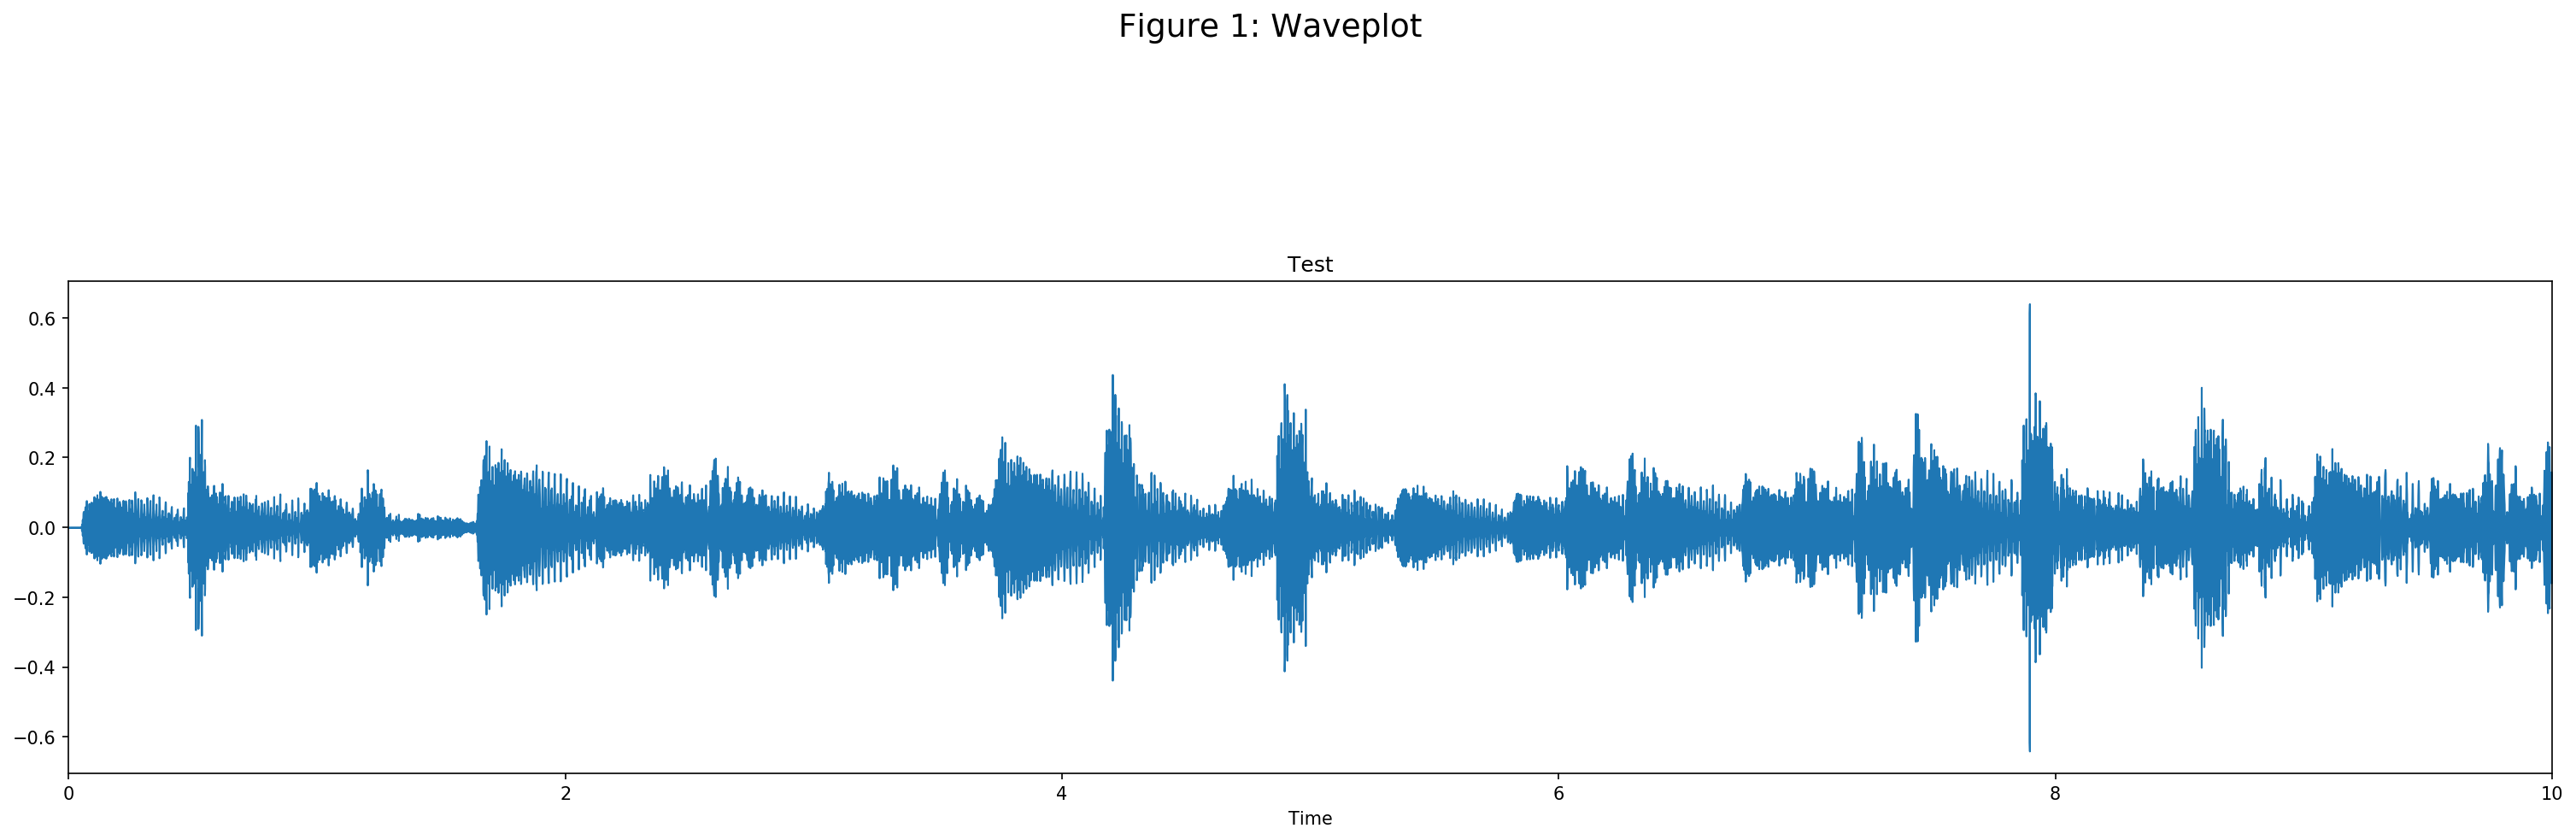

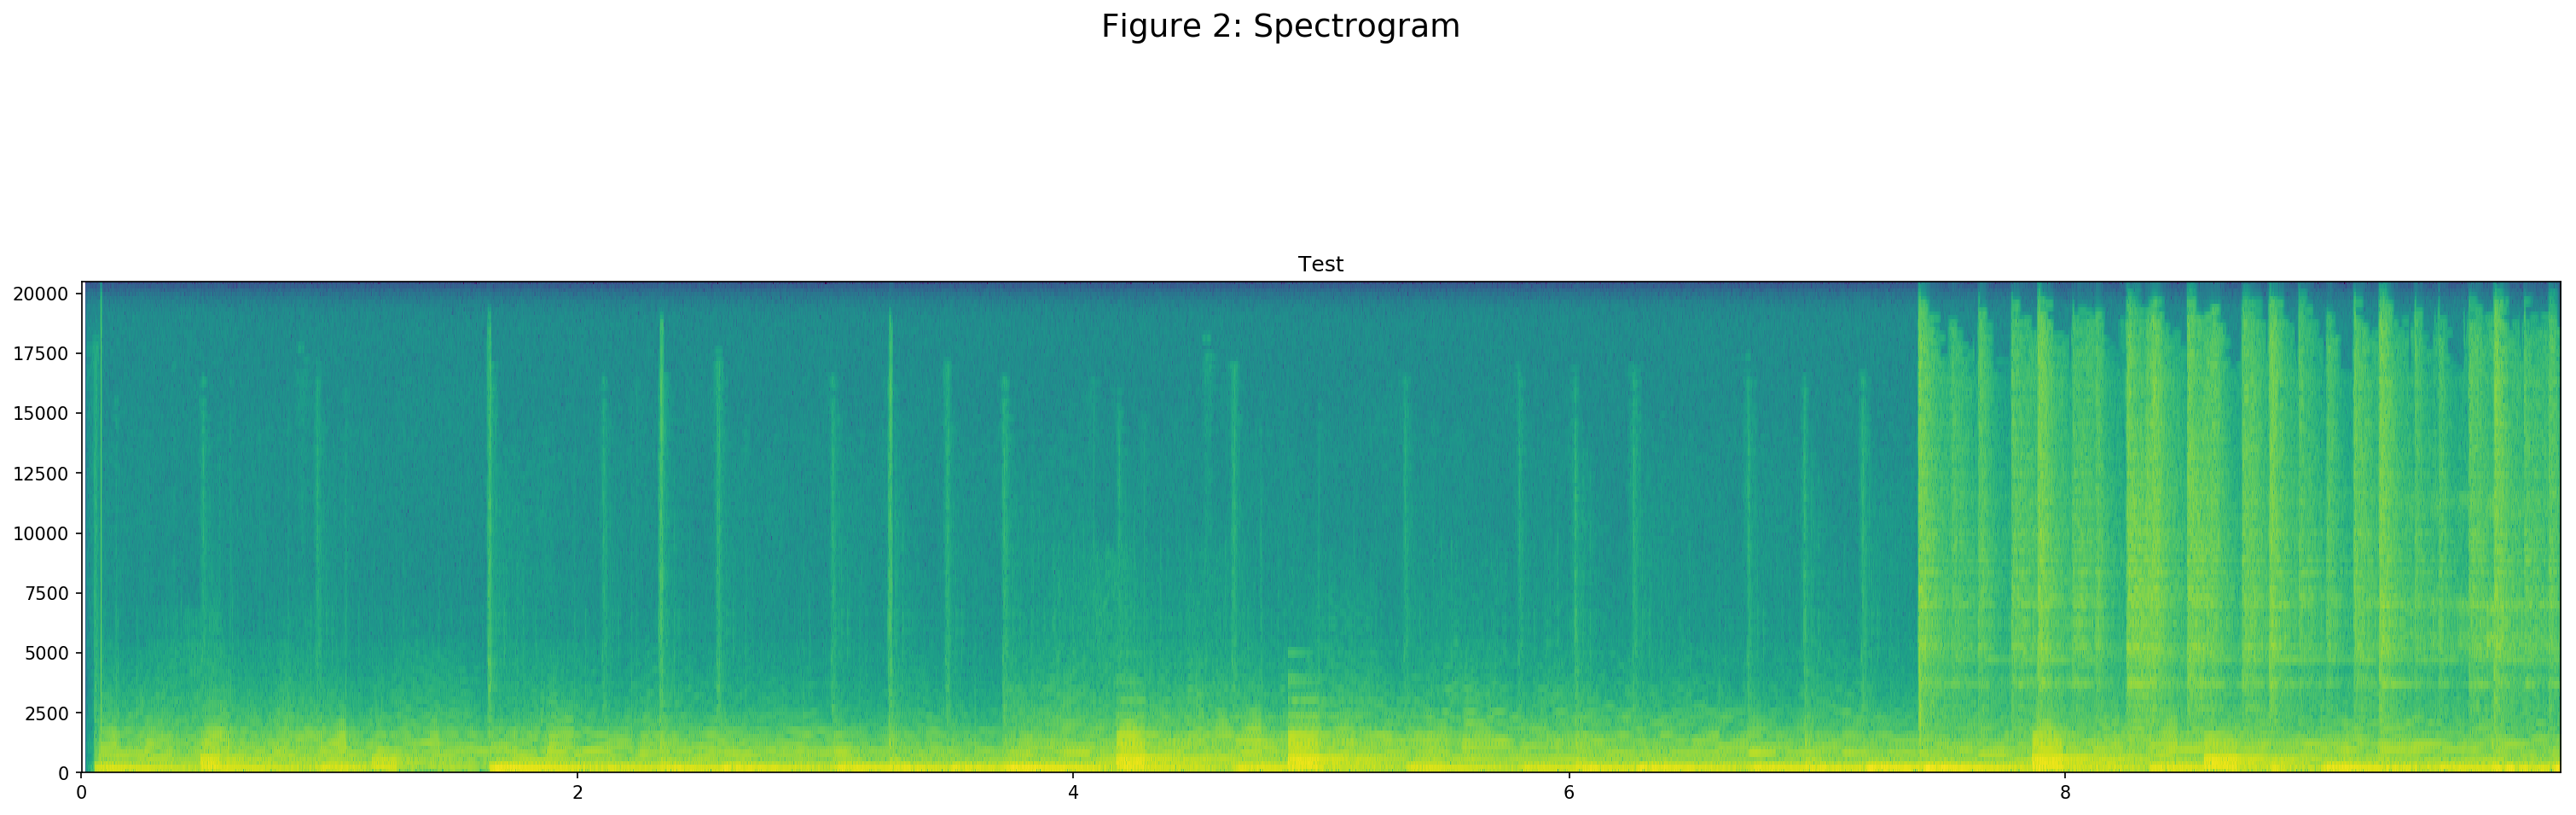

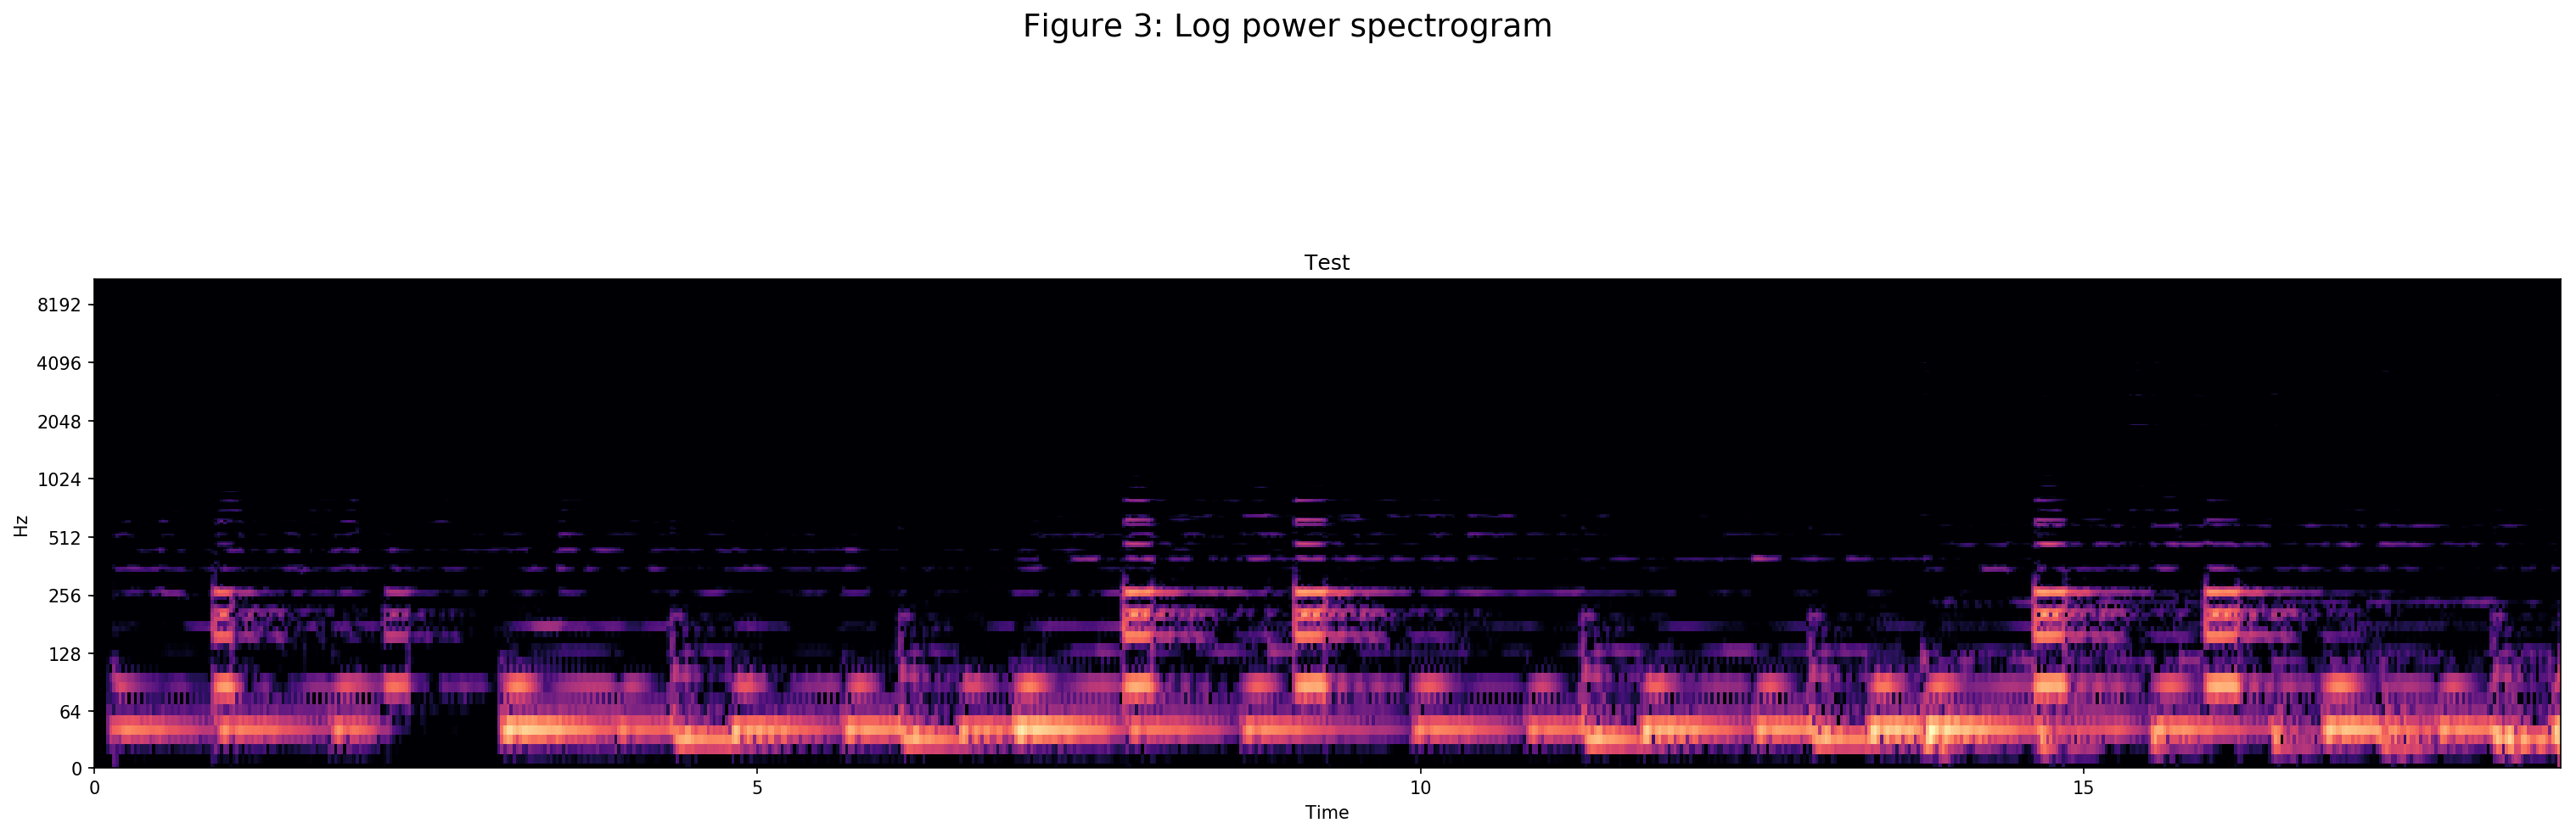

In [4]:
plot_all(sound_names = ['test'], raw_sounds = [y]) # you can plot them independently too!

# LIBRARY: pysndfx - available effects

Python wrapper for http://sox.sourceforge.net/ 

In [ ]:
# !pip install pysndfx 

#  https://pypi.org/project/pysndfx/

In [5]:
from pysndfx import AudioEffectsChain

def return_global_spec(fx):
    """
    Return available effects and their parameter defaults
    Use this to generate upper, lower bounds in data generation
    """
    
    def find_defaults(sig):
        store = {}
        for param in sig.parameters.values():
            if isclass(param.default):
                store[param.name] = 'Mandatory, no default'
            else:
                store[param.name] = param.default
        return store
    
    return {k: find_defaults(signature(v)) for k,v in getmembers(fx) if \
           k.endswith('_') is False and 'command' not in k}

test_class = AudioEffectsChain()
fx_suite = return_global_spec(test_class)
del fx_suite['custom']
print ('AVAILABLE EFFECTS: {}'.format(list(fx_suite.keys())))
# pprint (fx_suite) 

AVAILABLE EFFECTS: ['bandpass', 'bandreject', 'bend', 'chorus', 'compand', 'delay', 'echo', 'equalizer', 'fade', 'flanger', 'gain', 'highpass', 'highshelf', 'limiter', 'loop', 'lowpass', 'lowshelf', 'mcompand', 'noise_reduction', 'normalize', 'oops', 'overdrive', 'phaser', 'pitch', 'reverb', 'reverse', 'sinc', 'speed', 'synth', 'tempo', 'tremolo', 'trim', 'upsample', 'vad', 'vol']


# Example: Get expected values for a single effect

In [6]:
print ("Default values for 'overdrive' are {}".format(fx_suite.get('overdrive')))

Default values for 'overdrive' are {'gain': 20, 'colour': 20}


# soundFactory 

Class mimmicing generating functionality to test single effects on tracks

In [7]:
import soundFactory

## Regression with one effect

- fxManager class will always select value at random between an upper and lower bound
- this is how we augment our data! 

In [8]:
effects = {'overdrive' : {'gain' : (0, 75)}}
effects_manager = soundFactory.fxManager(effects = effects, exercise='regression')
effects_manager.apply_effects() # call all effects, modify fx_state 
print ('What we added {}'.format(effects_manager.applied))
print ('What pysndfx added {}'.format(effects_manager.state.command))
# run sample audio

What we added {'overdrive': {'gain': 71}}
What pysndfx added ['overdrive', 71, 20]


### We asked for gain  but implicitly added colour too! Be explicit with pysndfx functionality unless it doesn't make sense for effects to be mutually exclusive. 

In [9]:
# Lets create another effects manager and ask it to omit colour using a tuple of 2 Nones
effects2 = {'overdrive' : {'gain' : (0, 75), 'colour' : (None, None)}}
effects_manager2 = soundFactory.fxManager(effects = effects2, exercise='regression')
effects_manager2.apply_effects() # call all effects, modify fx_state 
# passing (None, None) to a parameter gave it 0
print (effects_manager2.applied) # if exercise == regression we'll omit fields with zeros
print (effects_manager2.state.command ) # correct

{'overdrive': {'gain': 19, 'colour': 0}}
['overdrive', 19, 0]


# Plotting modified waveforms 

In [10]:
y_with_effects = effects_manager2.state(y) # taken from librosa plotting cell

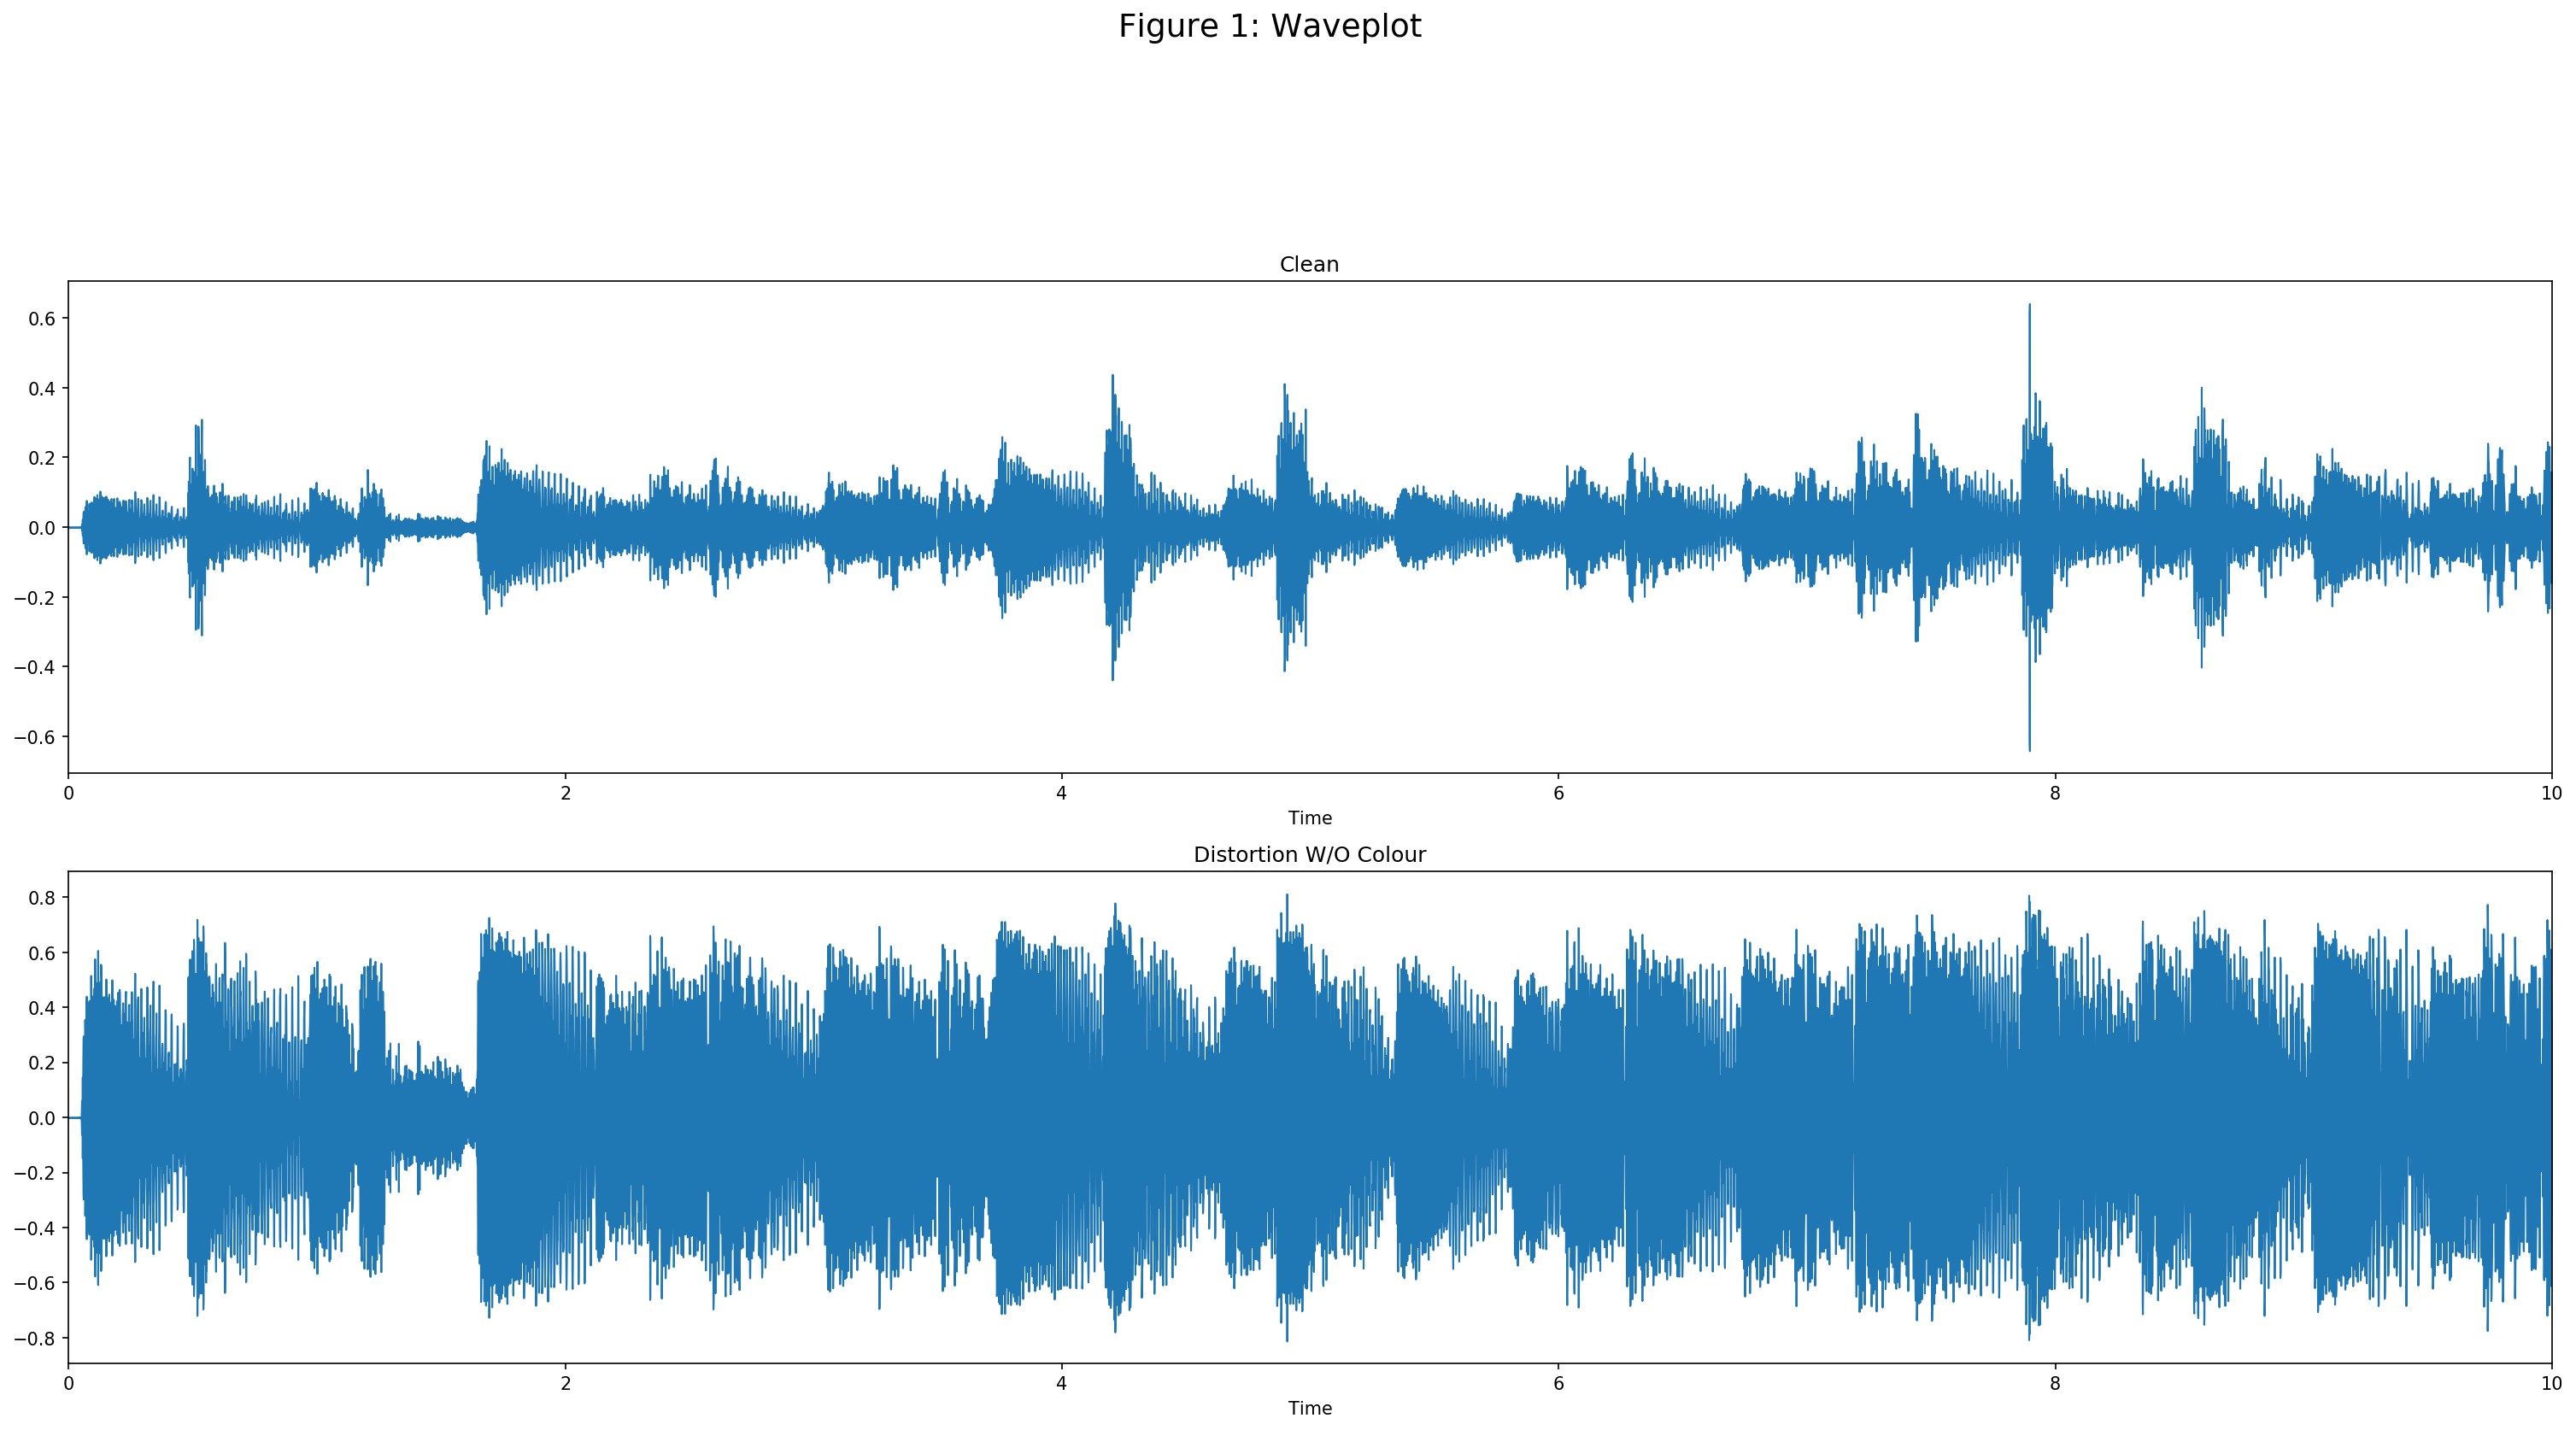

In [11]:
plot_waves(sound_names = ['clean', 'distortion w/o colour'], raw_sounds = [y,y_with_effects])

## Classification with multiple effects

- Again, random value between bounds
- This time we've requested overdrive.colour to be its default value
- For all classification tasks, fxManager will "toss coin" for whether to apply effect slated

In [12]:
# Test with 10
rows = []
for ii in range(10):
    # chooses between keeping the effect or not
    effects2 = {'overdrive' : {'gain' : (30, 75), 'colour' : 'default'}} 
    effects_manager3 = soundFactory.fxManager(effects = effects2, exercise='classification')
    effects_manager3.apply_effects()
    rows.append(effects_manager3.applied)    

# Binarize labels

In [13]:
def flatten(x, par = '', sep ='.'):
    """Flatten joining parent keys with dot"""
    store = {}
    for k,v in x.items():
        if isinstance(v,dict):
            store = {**store, **flatten(v, par =  par + sep + k if par else k)}
        else:
            store[par + sep + k] = v
    return store

label_df = pd.DataFrame(list(map(flatten, rows)))
label_df = label_df.where(label_df == 0).fillna(1)
label_df

,overdrive.colour,overdrive.gain
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,1.0
5,1.0,0.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


# FULL AUGMENTATION
Not yet a keras type generator, we're just creating a large amount of augmented data to practice with

In [24]:


def load_track(path, sr = 44100):
    
    """Unlikely we make modifications to this but nice to have it separately"""
    
    x, sr = librosa.load(path, sr = sr) # default
    return x

def augment(path, exercise, augment_n, effects): 

    """
    Procedurally augment track N times with sound effects, output determined by choice of ML exercise

    AudioEffectsChain effects are externalised as callable standalones
    Effects dictionary is traversed and parameters accumulated through function call
    Parameter values are randomized between bounds provided unless..
    Dictionary contains request for 'default' values, 'toggle' or None (0).
    Toggle being True or False values required
    Effects stored and returned with augmented track (labels, features)


    Parameters
    ----------
    path : str
        Filepath
    exercise : str
        'Regresison' or 'Classification'
    augment_n: int
        Number of generated files from the one
    effects: dict of str, int and bools
        Extent to which effect is added

    Returns
    -------
    list of tuples
        Tracks - np.array 
        Features - dictionary

    """

    track = load_track(path)

    all_tracks = []

    for sample in range(augment_n): # number we're augmenting

        fx_manager = AudioEffectsChain() # Initialized with 0 features

        features = {}

        for effect, settings in effects.items():

            standalone_effect = getattr(fx_manager, effect)
            # return random range within max settings applied
            settings_applied = {}

            for parameter, value in settings.items():

                default_ = signature(standalone_effect).parameters[parameter].default

                if value == 'toggle':
                    settings_applied[parameter] = random.choice([True, False])
                else:
                    if value == 'default':
                        if exercise == 'classification':
                            settings_applied[parameter] = random.choice([0, default_])
                            continue       
                        settings_applied[parameter] = default_
                    else:

                        if all([x is None for x in value]):
                            settings_applied[parameter] = 0
                            continue # set parameter value to 0
                            
                        lower, upper = [default_ if v == 'default' else v for v in value]
                        # At least have a max when giving settings!
                        randomized_val = random.randint(lower, upper)
                        if exercise == 'classification':
                            settings_applied[parameter] = random.choice([0, randomized_val])
                            continue
                        settings_applied[parameter] = randomized_val

            # Give effects to manager
            standalone_effect(**settings_applied)                         

            # Validate first effect, won't for additional records
            assert fx_manager.__dict__.get('command') != [], 'Settings not applied'

            # Record features
            features = {**{effect : settings_applied}, **features} 

        # Apply effects!
        augmented_track = fx_manager(track)

        # Since we're not modifying frequency input and output shape should match
        assert track.shape == augmented_track.shape, 'Output shape must match input'

        all_tracks.append((augmented_track, features))

    return all_tracks

def make_tabular(samples):
    """
    Return tracks (NDarray) and features (DataFrame) in tabular form  
    """

    X, features = zip(*samples)
    # give each element 2 dimensions (1, len(vector)) - change this!
    X = np.atleast_2d(*X) 
    stacked = np.stack(X)
    # Using dot notation for column names after unnesting records
    unnest = lambda x: flatten(x)
    effects_added = pd.DataFrame(list(map(unnest, features)))
    return (stacked, effects_added)


def sound_factory(path, soundfiles, batch_size , **kwargs):

    """
    Make augmented tracks

    """

    while True:

        # take n samples from series object passed
        soundfiles =  [path + x for x in soundfiles]
        batch_files = random.sample(soundfiles, k = batch_size)

        batch_inputs = []
        batch_outputs = []

        for soundfile in batch_files:    

            augmented_sound_files = augment(soundfile, **kwargs)  
            
            features, labels = make_tabular(augmented_sound_files)

            if kwargs.get('exercise') == 'classification':
                # binarize each column
                labels = labels.where(labels == 0).fillna(1)

            # pandas to numpy struct. array
            label_array = np.vstack(np.asarray(labels.to_records(index = False)))

            batch_inputs.append(features)
            batch_outputs.append(label_array)

        max_feature = max([i.shape for i in batch_inputs], key = lambda x: x[2])

        def padder(inp, max_shape): 
            # padding end with zeros matching maxfeature input shape
            zero_grid = np.zeros(max_shape)
            x,y,z = inp.shape
            zero_grid[:x, :y, :z] = inp
            return zero_grid

        # not sure if I have to keep stacking
        batch_x = np.vstack([padder(b, max_feature) for b in batch_inputs])
        # how do we represent outputs?
        batch_y = np.vstack(batch_outputs)

        yield (batch_x, batch_y)

        

## Generating data

In [67]:
# We already have a standard file split! 
data = json.load(fp = open('official_data_split.json', 'r'))
print ('Filesets available {}'.format(list(data.keys())))

pipeline_settings = {
    'effects' : effects,
    'exercise' : 'regression',
    'batch_size': 50, # number of audio tracks taken
    'augment_n' : 2 # number of augmentations per track
}
print ('Anticipated number of examples : {}'.format(
    pipeline_settings.get('batch_size') * pipeline_settings.get('augment_n')))

# Instantiating generator
train_generator = sound_factory(path = DOWNLOAD_PATH, soundfiles = data.get('train'), **pipeline_settings)
# generating, call once - not a keras type generator yet
train_X, train_Y = next(train_generator) 


Filesets available ['train', 'test']
Anticipated number of examples : 100


In [195]:
train_X.shape #

(100, 1, 110250)

In [196]:
train_Y[0] # numpy record type

array([(9,)], dtype=(numpy.record, [('overdrive.gain', '<i8')]))

# View labels as Pandas dataframe?

In [197]:
columns = train_Y.dtype.fields.keys()
pd.DataFrame.from_records(train_Y.view(np.int), columns = list(columns)).head()

,overdrive.gain
0,9
1,63
2,63
3,22
4,47


# Further w/ gudiance on training

> Tristan's Keras implementation of sincnet - https://github.com/mravanelli/SincNet
>> https://github.com/AI-Guru/SincNet

> Kapre Library provides trainable layers in lieu of preprocessed feature engineering 
>> https://github.com/keunwoochoi/kapre/blob/master/examples/example_codes.ipynb
    
> Jake G's urban sound classification - I stole his plottig functions
>> https://github.com/jake-g/urban-sound-classification/blob/github/utils.py
 
>Another attempt, this one with acompanying blog - feature engineer is interesting in this and the aforementioned
>> https://github.com/aqibsaeed/Urban-Sound-Classification
